## Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонт прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3

2. Оцените ошибку модели из п.1 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.



## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

In [2]:
energy_data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

energy_data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Посмотрим на ряд потребления энергии помесячно

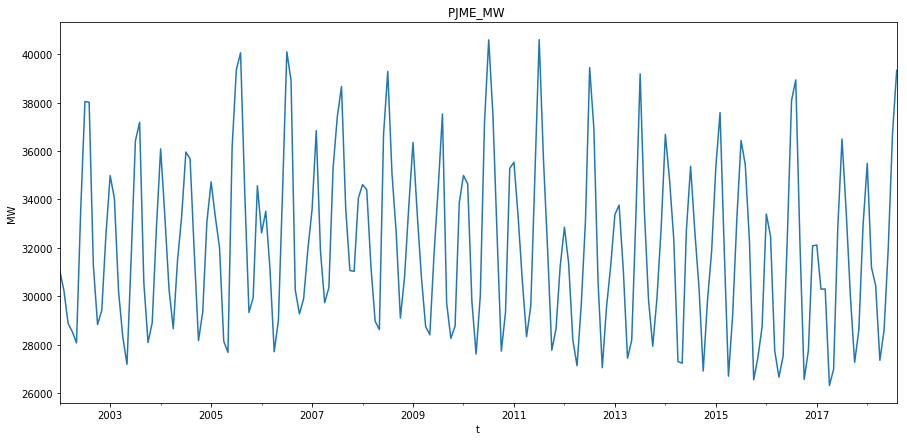

In [3]:
energy_data_per_month = energy_data.resample('M').mean()

energy_data_per_month['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

Посмотрим на первые разности ряда потребления энергии.

In [4]:
energy_data_first_diff = energy_data[['PJME_MW']].diff()

Text(0.5, 1.0, 'Потребление энергии, МВт')

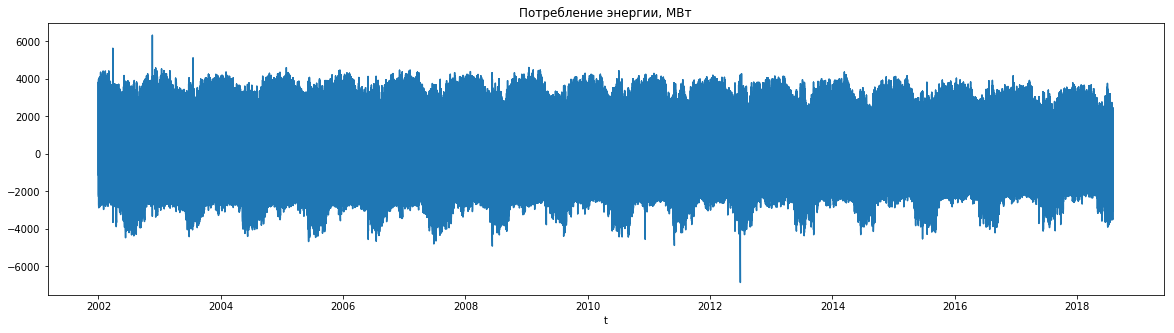

In [5]:
plt.figure(figsize=(20,5))
plt.plot(energy_data_first_diff.index, energy_data_first_diff['PJME_MW'])
plt.xlabel('t')
plt.title('Потребление энергии, МВт')

Проверим на стационарность основной ряд с помесячной разбивкой и ряд первых разностей. В качестве нулевой гепотезы возьмем предположение что ряд не стационарен.

In [6]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [7]:
DF_energy_data_per_month = sm.tsa.stattools.adfuller(energy_data_per_month['PJME_MW'].values,regression='ctt')
print('коэффициент ADF для основного ряда потребления энергии: p-value = ', DF_energy_data_per_month[1])


DF_energy_data_first_diff = sm.tsa.stattools.adfuller(energy_data_first_diff['PJME_MW'].values[1:],regression='ctt')
print('коэффициент ADF для первых разностей потребления энергии: p-value = ', DF_energy_data_first_diff[1])

коэффициент ADF для основного ряда потребления энергии: p-value =  0.5247860093678629
коэффициент ADF для первых разностей потребления энергии: p-value =  0.0


ADF показал, что ряд первых разностей стационарный, тогда как ряд помесячный нет. 
Исходя из этого наш основной ряд является интегрированным рядом т.е. лаги изменения потребления энергии стационарны на часовых интервалах.

Это говорит о том, что нужно разделить модели на отдельные составляющие - сезонность у потребления энергии и тренд по месяцам у нефти отделим от стационарных колебаний вокруг этих компонент.

In [8]:
energy_data_per_day=energy_data.resample('D').mean()

Воспользуемся экспаненциальным сглаживанием для выделения основной части ряда. На графике ниже зеленым обозначен шум в данных. Видно, что он колеблется в области 0. Для сравнения с экспоненциальным сглаживанием добавим скользящее среднее. По графику видно, что они весьма схожи, но это зависит от конкретных значений альфа(чем меньше альфа, тем сильнее сглаживание).

Text(0.5, 1.0, 'PJM')

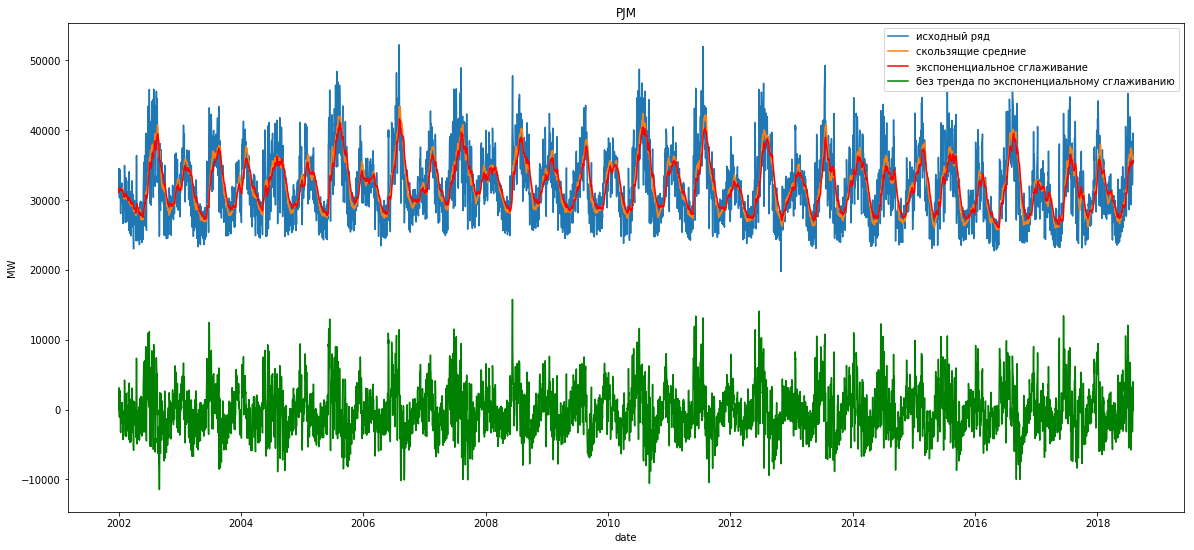

In [18]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

N2 = 24
energy_data_exp = exponential_smoothing(energy_data_per_day['PJME_MW'], 0.05)

energy_data_rolling = pd.DataFrame(data = energy_data_per_day[['PJME_MW']])


plt.figure(figsize=(20, 9))
plt.plot(energy_data_rolling.index, energy_data_rolling['PJME_MW'], label='исходный ряд')
plt.plot(energy_data_rolling['PJME_MW'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(energy_data_rolling.index, energy_data_exp, color = 'red', label="экспоненциальное сглаживание");
plt.plot(energy_data_rolling.index, energy_data_rolling['PJME_MW'] - energy_data_exp, color = 'green', 
         label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('date')
plt.ylabel('MW')
plt.legend()
plt.title('PJM')

Посомтрим поближе. Рассмтроим данные за 3 года. По графику видно, что шум следует за сезонностью в основных данных.

Text(0.5, 1.0, 'PJME_MW')

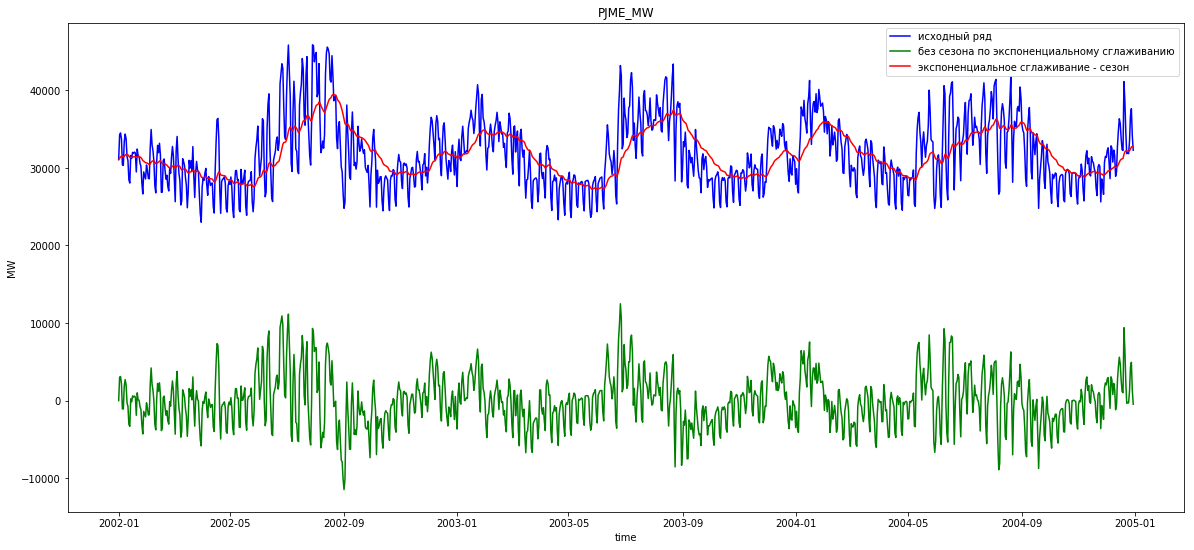

In [19]:
plt.figure(figsize=(20, 9))
plt.plot(energy_data_per_day.index[:365*3], energy_data_per_day['PJME_MW'].values[:365*3], '-b',label='исходный ряд')

plt.plot(energy_data_per_day.index[:365*3], energy_data_per_day['PJME_MW'].values[:365*3] - energy_data_exp[:365*3] , 
         color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(energy_data_per_day.index[:365*3], energy_data_exp[:365*3] , 
         color = 'red', label="экспоненциальное сглаживание - сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [20]:
energy_data_seson_free = pd.DataFrame(data = (np.array(energy_data_per_day['PJME_MW'])\
                                              .reshape((energy_data_per_day['PJME_MW'].shape[0],1))-energy_data_exp))
DF_seson_free = sm.tsa.stattools.adfuller(energy_data_seson_free.iloc[:,0] , regression = 'ctt')
print(f'p-value: {DF_seson_free[1]}')

p-value: 4.282974615247152e-11


В результате удаления явно сезонной составляющей для потребления энергии получаем стационарный ряд.

Для прогнозирования данных экспоненциального сглаживания необходимо построить новые признаки.

In [21]:
energy_data_feature = pd.DataFrame(data = energy_data_exp, index = energy_data_rolling.index, columns=['PJME_MW'])
energy_data_feature.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
energy_data_feature['t'] = 0
energy_data_feature.iloc[1:,1]=energy_data_feature.iloc[:-1,0].values
energy_data_feature['t1']=0
energy_data_feature.iloc[2:,2]=energy_data_feature.iloc[:-2,0].values
energy_data_feature['t2']=0
energy_data_feature.iloc[3:,3]=energy_data_feature.iloc[:-3,0].values
energy_data_feature.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
energy_data_feature['exp_0_01'] = exponential_smoothing(energy_data_feature['PJME_MW'], 0.01)
energy_data_feature['exp_0_05'] = exponential_smoothing(energy_data_feature['PJME_MW'], 0.05)
energy_data_feature['exp_0_1'] = exponential_smoothing(energy_data_feature['PJME_MW'], 0.1)
# добавим разности - 1-й порядок
energy_data_feature['diff1'] = 0
energy_data_feature['diff1'].iloc[1:] = energy_data_feature.iloc[1:,0].values - energy_data_feature.iloc[:-1,0].values


energy_data_feature.head()

C:\Users\NKP_IT\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,PJME_MW,t,t1,t2,exp_0_01,exp_0_05,exp_0_1,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31088.691137,31096.643143,159.040127
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31104.425782,31127.317233,163.604787
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31125.153881,31166.484286,115.603714
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31142.060918,31196.165319,-55.693138


Облако корреляции построим с 1 января 2016 года

Text(0.5, 1.0, 'Облако корреляции')

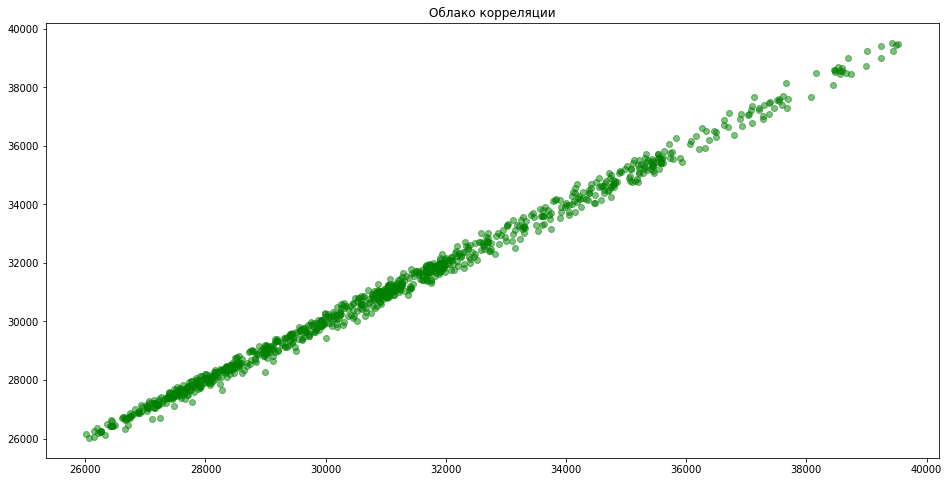

In [22]:
plt.figure(figsize = (16,8))
plt.scatter(energy_data_feature['2016-01-01':].iloc[1:,0], energy_data_feature['2016-01-01':].iloc[:-1,0].values, 
            c="g", alpha=0.5)
plt.title('Облако корреляции')

In [23]:
energy_data_feature.columns

Index(['PJME_MW', 't', 't1', 't2', 'exp_0_01', 'exp_0_05', 'exp_0_1', 'diff1'], dtype='object')

Разделим временной ряд на тестовый и тренировочный набор данных. Разделять будем по фиксированной дате. 1 января 2016 года.

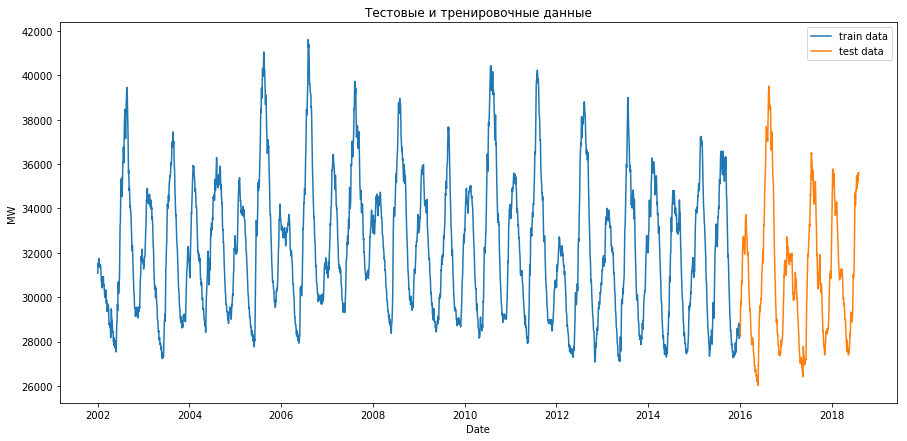

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


# сделаем примеры и модель 
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()
h= 1
train_data, test_data = split_data(energy_data_feature, '01-01-2016')

X_train_data = train_data.iloc[:-h,:]
y_train_data = train_data[energy_data_feature.columns[0]].values[h:]
X_test_data = test_data.iloc[:-h,:]
y_test_data = test_data[energy_data_feature.columns[0]].values[h:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Date')
plt.ylabel('MW')
plt.plot(train_data.index,train_data[energy_data_feature.columns[0]], label='train data' )
plt.plot(test_data.index, test_data[energy_data_feature.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

Спрогнозируем экспоненциальное сглаживание на 1 день вперед.

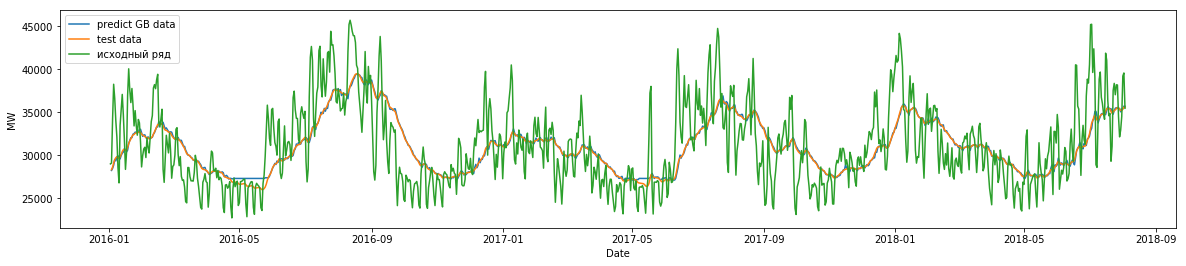

ошибка градиентного бустинга :   0.5415155801995442 %


In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit(X_train_data, y_train_data) 

X_test_predict = model_gb.predict(X_test_data)

plt.figure(figsize=( 20, 4 ))

plt.xlabel('Date')
plt.ylabel('MW')
plt.plot(test_data.index[h:], X_test_predict, label='predict GB data' )
plt.plot(test_data.index[h:], y_test_data, label='test data')
plt.plot(energy_data_per_day.loc['2016-01-02':].index, energy_data_per_day.loc['2016-01-02':]['PJME_MW'], label='исходный ряд')


plt.legend()
plt.show()

mae = mean_absolute_percentage_error(y_true=y_test_data, y_pred=X_test_predict)

print('ошибка градиентного бустинга :  ', mae, '%')

Модель авторегрессии с горизонтом прогноза 1 (т.е. считаем на один шаг вперед) работает замечательно на всем интервале теста. Значение ошибки для нее не превышает 0.55%. Однако моделируем только нестационарный процесс и на коротком интервале прогноза. увеличим интервал прогноза до 10 шагов вперед. 

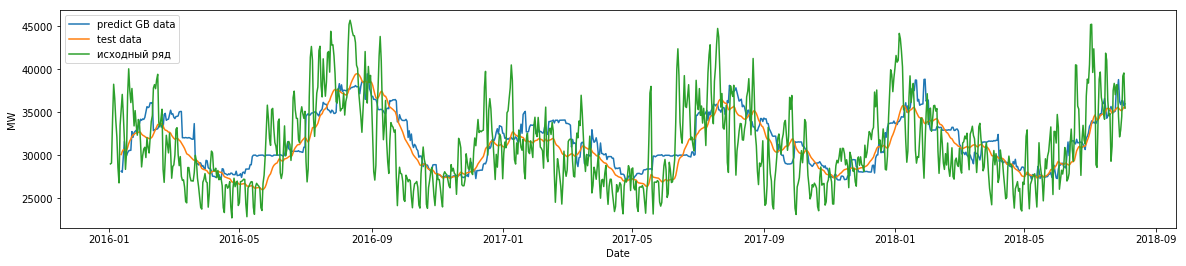

ошибка градиентного бустинга :   3.7678385277939035 %


In [26]:
h=10
X_train_data = train_data.iloc[:-h,:]
y_train_data = train_data[energy_data_feature.columns[0]].values[h:]
X_test_data = test_data.iloc[:-h,:]
y_test_data = test_data[energy_data_feature.columns[0]].values[h:]

model_gb.fit(X_train_data, y_train_data) 
X_test_predict = model_gb.predict(X_test_data)

plt.figure(figsize=(20, 4))

plt.xlabel('Date')
plt.ylabel('MW')
plt.plot(test_data.index[h:], X_test_predict, label='predict GB data' )
plt.plot(test_data.index[h:], y_test_data, label='test data')
plt.plot(energy_data_per_day.loc['2016-01-02':].index, energy_data_per_day.loc['2016-01-02':]['PJME_MW'], 
         label='исходный ряд')

plt.legend()
plt.show()

mae = mean_absolute_percentage_error(y_true=y_test_data, y_pred=X_test_predict)

print('ошибка градиентного бустинга :  ', mae, '%')

Очевидно, все стало не так хорошо (почти 4% ошибки по основной линии прогноза и много по реальному ряду)

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
        Ряд не стационарен. Имеется суточная сезонность(день/ночь), годичная сезонность(зима/лето). Имеется восходящий тренд(привет от Греты).
        
    б) Количество денег, которые тратят покупатели в интернет магазине.
        Ряд не стационарен. Имеется сезонность суточная(ночью все спят), имеется сезонность годичная(перед праздниками всегда больше тратят). Имеется восходящий тренд - инфляция(привет из 1864).
    в) Вес растущего котенка.
        Ряд не стационарен. Ярковыраженной сезонности нет, хотя если котенок летом живет на природе, то можно предположить сезонность в его весе. Имеется тренд, котенок взрослеет, растет, его вес увеличивается. Потом он вырастает и становиться ленивым, мало двигается, тренд сохраняется.
    г) Прирост объема деревьев в лесу от времени
        Ряд не стационарен. Имеется сезонность, зимой деевьев растер мало(от слова совсем). Имеется цикличность, раз в 100500 лет прилетает астероид, земля впадаев в ледниковую спячку, объем деревьев падает сильно. Имеется нисходящий тренд - вырубка лесов(Шведская икея сама себя стульями не обеспечит).

5. Какие из рядов на картинке стационарны на первый взгляд? (презентация, слайд номер 21)
    a) - Не стационарен, имеется ярковыраженная сезонность
    b) - Возможно, ряд стационарен, надо проверять
    c) - Ряд не стационарен, заметна цикличность, в целом ряд имеет пики и падения.
    d) - Не стационарен, имеется ярковыраженная сезонность и цикличность
    e) - Не стационарен, имеется нисходящий тренд
    f) - Скорее всего не стационарен, но надо проверять, похоже что имеется сезонность, цикличность
    g) - Сложно сказать, возможно ряд стационарен, надо проверять, имеется цикличность
    h) - Не стационарен, имеется ярковыраженная сезонность
    i) - Не стационарен, имеется ярковыраженный тренд